### Data-vector blinding for the power spectrum multipoles

Example notebook showing how to implement the data-vector level blinding for the galaxy power spectrum multipoles.

In [1]:
from desilike.theories import Cosmoprimo
from desilike.samples import Profiles, Chain
from cosmoprimo.fiducial import AbacusSummit

from desiblind import TracerPowerSpectrumMultipolesBlinder

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'


def get_tracer_label(tracer):
    return tracer.split('_')[0].replace('+', 'plus')

def get_theory():
    """Instance of desilike theory model"""
    from desilike.theories.galaxy_clustering import FixedPowerSpectrumTemplate, DirectPowerSpectrumTemplate, REPTVelocileptorsTracerPowerSpectrumMultipoles
    from desilike.theories import Cosmoprimo
    cosmo = DirectPowerSpectrumTemplate(fiducial='DESI').cosmo
    cosmo = Cosmoprimo(fiducial='DESI', engine='class', lensing=True)
    template = DirectPowerSpectrumTemplate(z=window.theory.get(ells=0).z, fiducial='DESI', cosmo=cosmo)
    theory = REPTVelocileptorsTracerPowerSpectrumMultipoles(template=template)
    return theory

def get_synthetic_data(statistic='mesh2_spectrum_poles', tracer='LRG', zmin=0.4, zmax=0.6,
    region='GCcomb', ells=[0, 2, 4], weights='default_fkp', kmin=0.0, kmax=0.3, rebin=5):
    """Synthetic data from Abacus-HF mocks for testing."""
    import lsstypes as types
    dirname = Path('/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/unblinded_data/dr2-v2/')
    covariance = types.read(dirname / f'covariance_{statistic}_{tracer}_z{zmin}-{zmax}_{region}_{weights}.h5')
    observable = covariance.observable.select(k=slice(0, None, rebin)).select(k=(kmin, kmax)).get(ells=ells)
    poles = [observable.get(ell) for ell in ells]
    k = poles[0].coords('k')
    poles = [pole.value() for pole in poles]
    covariance = covariance.at.observable.match(observable)
    covariance = covariance.value()
    window = types.read(dirname / f'window_{statistic}_{tracer}_z{zmin}-{zmax}_{region}_{weights}.h5')
    window = window.at.observable.match(observable)
    window = window.at.theory.select(k=(0, 0.35))
    return k, poles, covariance, window

The blinding procedure does the following:

$P_{\rm blind}(k) = P(k) - W(k, k') P_{\rm ref}(k) + W(k, k') P_{\rm shift}(k)$,

where $P_{\rm ref}(k)$ is computed with a *reference* cosmology (reasonably a good match to the data), while 
$P_{\rm shift}(k)$ is computed with a *shift* cosmology (the blinding cosmology).

In [2]:
# we read the reference parameters from a joint full-shape fit to all GQC tracers

profiles = Profiles.load('../scripts/profiles_fs.npy')
bestfit = profiles.bestfit.choice(index='argmax', input=True)

In [3]:
# we instantiate TracerPowerSpectrumMultipolesBlinder, which will provides
# the necessary tools to apply the blinding. We then loop
blinder = TracerPowerSpectrumMultipolesBlinder()

# we then loop over each tracer and use the .add_observable method to add their
# data to the blinding class. We note that the "nuisance parameters" are different
# for each tracer (the Profile/Chain files have entries like "LRG_z0_b1p".

list_zrange = [
    ('BGS_BRIGHT-21.35', 0, (0.1, 0.4)), 
    ('LRG', 0, (0.4, 0.6)),
    ('LRG', 1, (0.6, 0.8)),
    ('LRG', 2, (0.8, 1.1)),
    ('ELG_LOPnotqso', 1, (1.1, 1.6)),
    ('QSO', 0, (0.8, 2.1)),
]

region = 'GCcomb'
ells = [0, 2, 4]
cosmo_param_names = ['h', 'omega_cdm', 'omega_b', 'logA']
nuisance_param_names = ['b1p', 'b2p', 'bsp', 'alpha0p', 'alpha2p', 'alpha4p', 'sn0p', 'sn2p', 'sn4p']

for tracer, iz, zrange in list_zrange:
    tracer_label = get_tracer_label(tracer)
    namespace = '{tracer}_z{iz}'.format(tracer=tracer_label, iz=iz)
    zmin, zmax = zrange

    k, poles, covariance, window = get_synthetic_data(tracer=tracer, zmin=zmin, zmax=zmax, region=region, ells=ells)
    theory = get_theory()
    theory.init.update(k=window.theory.get(ells=0).coords('k'))

    cosmo_params = {param: bestfit[f'{param}'].value for param in cosmo_param_names}
    nuisance_params = {param: bestfit[f'{namespace}.{param}'].value for param in nuisance_param_names}
    reference_params = cosmo_params | nuisance_params
    
    blinder.add_observable(
        name=namespace,
        k=k,
        data=poles,
        theory=theory,
        covariance=covariance,
        window=window,
        reference_params=reference_params
)

In [4]:
# we now apply the blinding to each tracer. the "shifted_params" are provided
# to the .apply_blinding method. Parameters that are not included in the shifted
# dictionary default to the reference values defined earlier

# note that the shifted parameters are defined manually in the example below,
# but ideally we would be sampling them directly from a chain


for tracer, iz, zrange in list_zrange:
    tracer_label = get_tracer_label(tracer)
    namespace = '{tracer}_z{iz}'.format(tracer=tracer_label, iz=iz)

    shifted_params = {'b1p': 1.2}
    blinder._apply_blinding(
        name=namespace,
        shifted_params=shifted_params,
    )

    # we can apply multiple blinding shifts to the data. Rather than cumulatively
    # shifting the original vector, each blinded data vector is appended to a list
    
    shifted_params = {'b1p': 1.5}
    blinder._apply_blinding(
        name=namespace,
        shifted_params=shifted_params,
    )

# for instance, the two blinded data vectors for LRG1 can be accessed as
# blinder.LRG_z0.blinded_data , which will yield an array of shape
# (n_blinding, n_multipoles, k_bins)

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


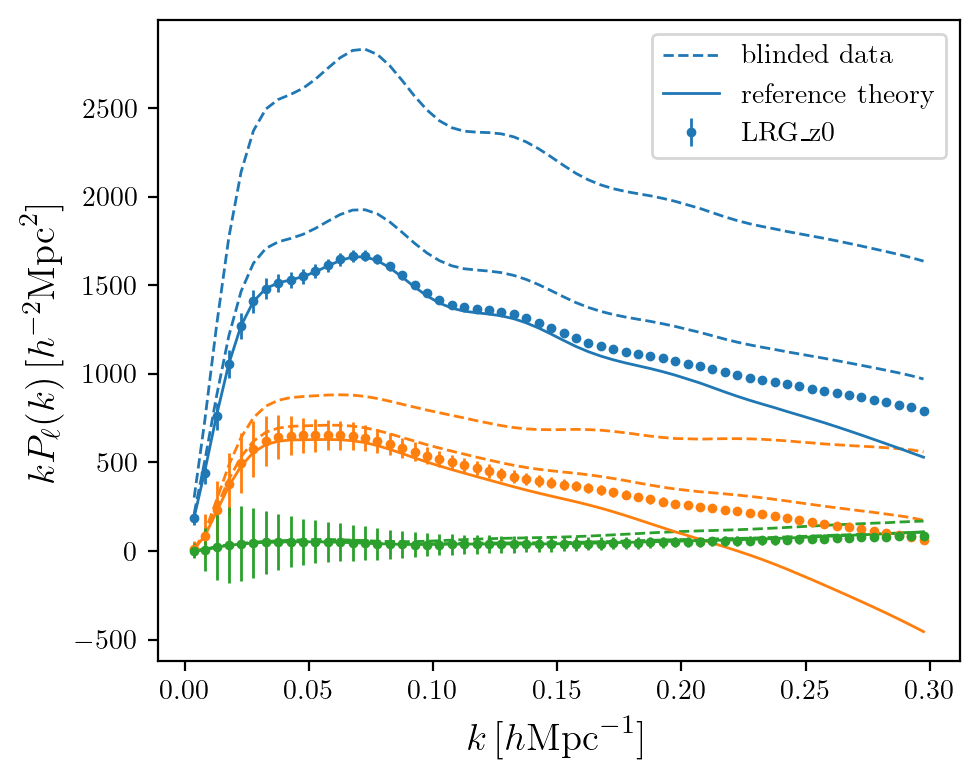

In [5]:
# we can plot the original and blided data, together with the reference theory.
# blinded_ids specify which blinding realization we want to show

fig, ax = blinder.plot_observables(name='LRG_z0', show_blinded=True, blinded_ids=[0, 1])

In [6]:
# we save the shifts that are needed to blind the measurements to disk.
# this will then allow us to use those shifts to blind any input data
# without having to go through all the trouble we set up above

blinder.save_blinded_data(save_dir='/global/cfs/cdirs/desicollab/users/epaillas/y3-growth/dump')

In [7]:
# load the shifts and use a high-level method that blinds input data.

k, poles, covariance, window = get_synthetic_data(
    tracer='LRG',
    zmin=0.4,
    zmax=0.6,
    region='GCcomb',
    ells=[0, 2, 4]
)

blinded_data = TracerPowerSpectrumMultipolesBlinder.apply_blinding(
    name='LRG_z0',  # TODO add an internal function so that the user only needs to pass tracer name, zmin, zmax?
    k=k,
    data=poles,
    ells=ells,
)

np.shape(blinded_data)

(3, 60)

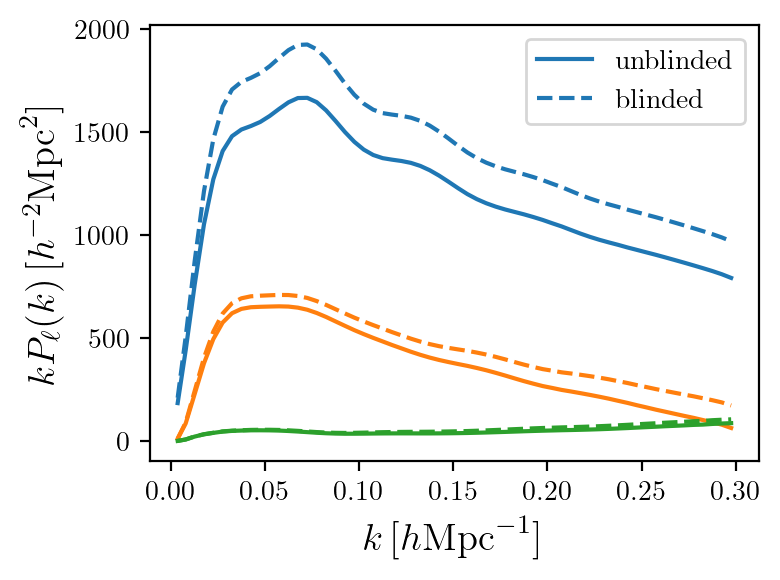

In [8]:
# let's plot it

fig, ax = plt.subplots(figsize=(4, 3))

for iell, ell in enumerate([0, 2, 4]):
    ax.plot(k, k * poles[iell], label='unblinded' if iell == 0 else None, color=f'C{iell}')
    ax.plot(k, k * blinded_data[iell], label='blinded' if iell == 0 else None, color=f'C{iell}', ls='--')

ax.legend()
ax.set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$k P_\ell(k)\,[h^{-2}{\rm Mpc}^{2}]$', fontsize=14)
plt.tight_layout()
plt.show()